In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve, validation_curve
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, roc_auc_score
)
import joblib
import time

# Para reproducibilidad
RANDOM_STATE = 42

In [3]:
# Parámetros
DATASET = 'iris'  # opciones: 'iris', 'wine', 'breast_cancer', 'digits'
TEST_SIZE = 0.25
CV_FOLDS = 5
SCORING = 'accuracy'  # puedes cambiar a 'f1_macro' para datasets desbalanceados

In [4]:
# Cargar dataset (construcción de DataFrame para facilitar EDA)
if DATASET == 'iris':
    data = datasets.load_iris()
elif DATASET == 'wine':
    data = datasets.load_wine()
elif DATASET == 'breast_cancer':
    data = datasets.load_breast_cancer()
elif DATASET == 'digits':
    data = datasets.load_digits()
else:
    raise ValueError('Dataset no soportado. Usa "iris", "wine", "breast_cancer" o "digits"')

X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')
CLASS_NAMES = list(data.target_names)

print(f"Dataset: {DATASET}")
print(f"Características: {X.shape[1]}")
print(f"Número de instancias: {X.shape[0]}")
print(f"Clases: {CLASS_NAMES}")

Dataset: iris
Características: 4
Número de instancias: 150
Clases: [np.str_('setosa'), np.str_('versicolor'), np.str_('virginica')]


In [5]:
# Exploración rápida: primeras filas y estadísticas
display(X.head())
print('\nDistribución de clases:')
print(y.value_counts().sort_index())

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2



Distribución de clases:
target
0    50
1    50
2    50
Name: count, dtype: int64


<Figure size 1400x800 with 0 Axes>

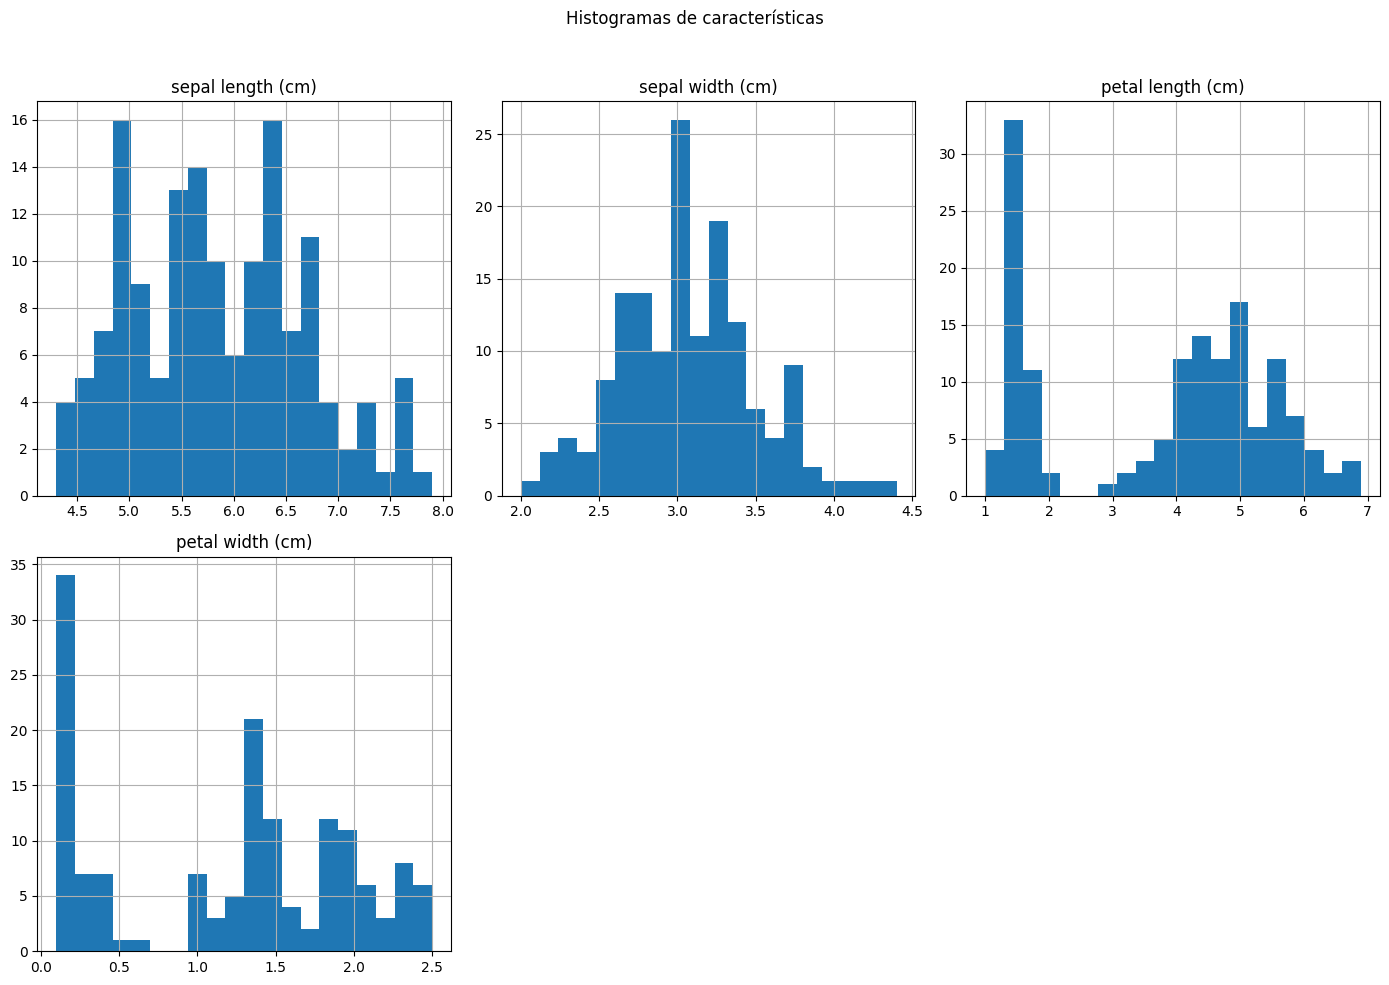

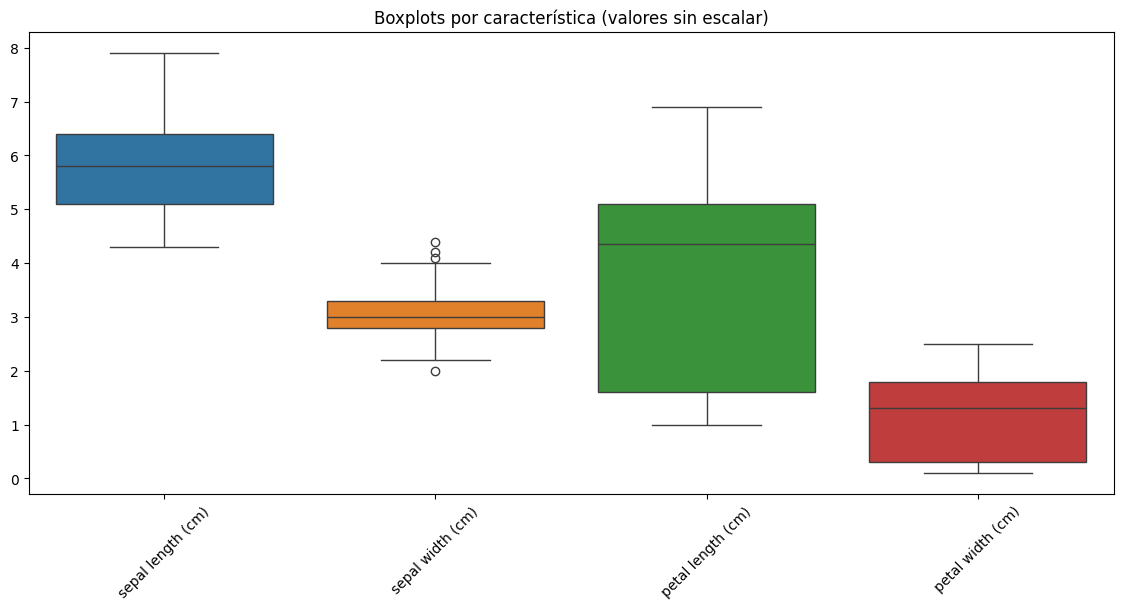

In [6]:
# Visualización 1: histogramas y boxplots por característica
plt.figure(figsize=(14, 8))
X.hist(bins=20, layout=(int(np.ceil(X.shape[1]/3)), 3), figsize=(14, 10))
plt.suptitle('Histogramas de características')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

plt.figure(figsize=(14, 6))
sns.boxplot(data=X)
plt.title('Boxplots por característica (valores sin escalar)')
plt.xticks(rotation=45)
plt.show()

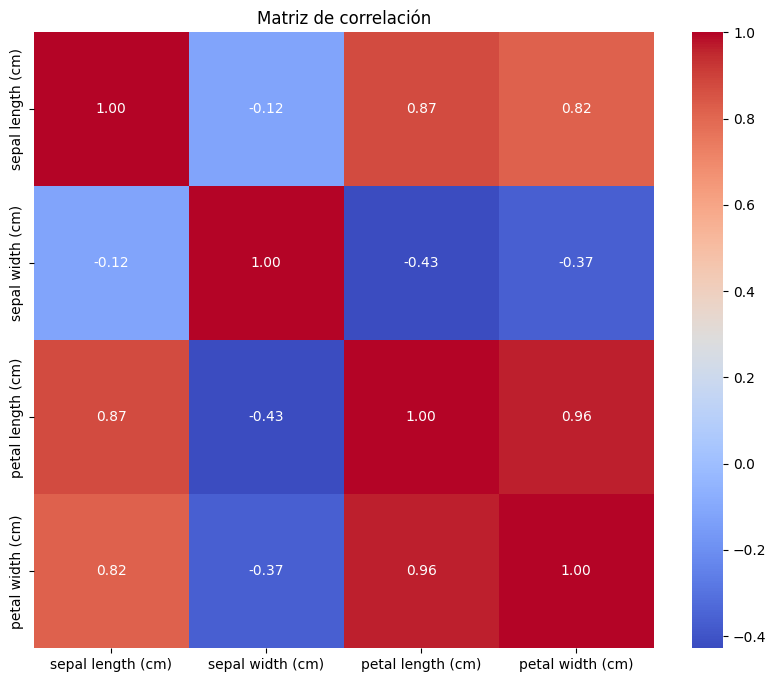

In [7]:
# Visualización 2: correlación
plt.figure(figsize=(10, 8))
corr = X.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matriz de correlación')
plt.show()

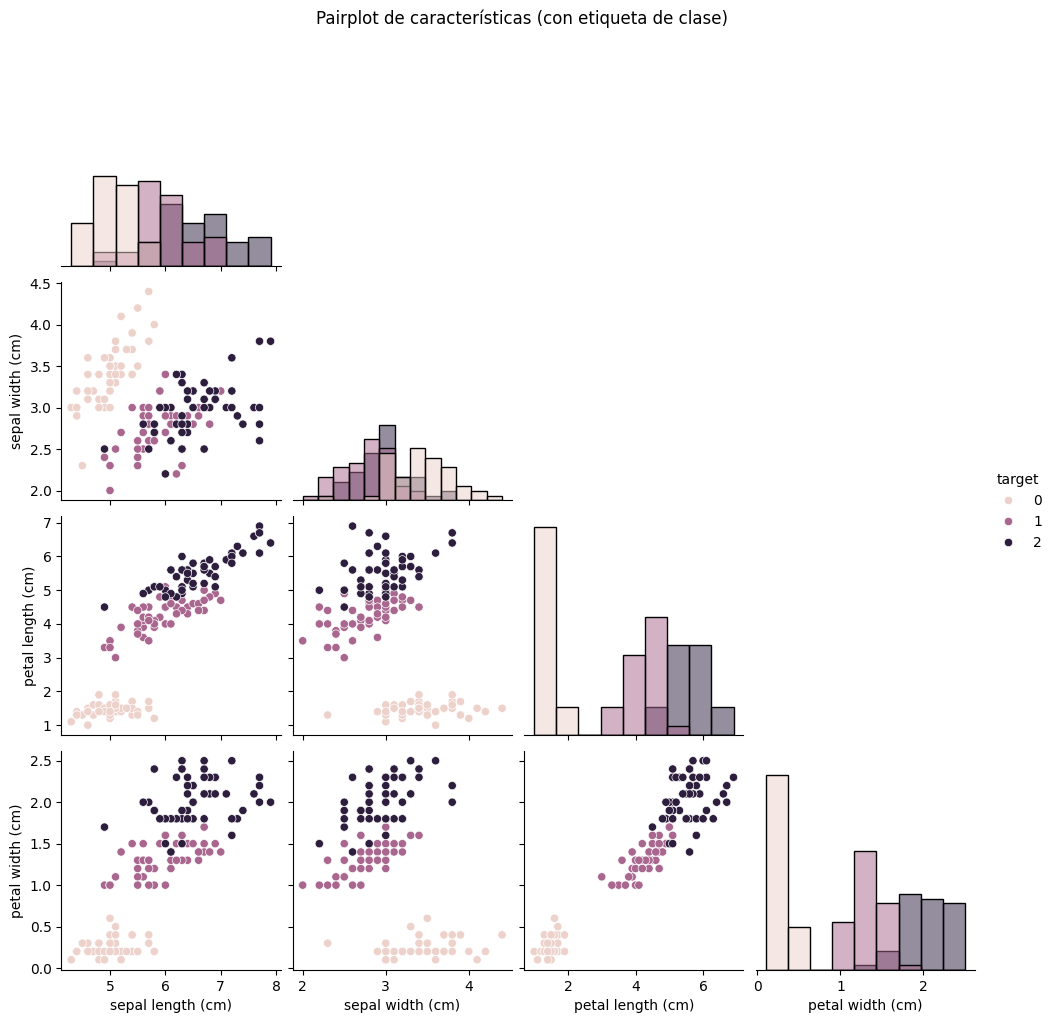

In [8]:
# Pairplot (si pocas características) o PCA + scatter si muchas
if X.shape[1] <= 6:
    df_pair = pd.concat([X, y], axis=1)
    sns.pairplot(df_pair, hue='target', diag_kind='hist', corner=True)
    plt.suptitle('Pairplot de características (con etiqueta de clase)', y=1.02)
    plt.show()
else:
    # Si hay muchas características, mostrar PCA 2D
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    X_pca = pca.fit_transform(X)
    df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    df_pca['target'] = y.values
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='target', palette='tab10')
    plt.title('PCA 2D - primer y segundo componente')
    plt.show()

In [13]:
### Preprocesado y separación train/test


In [14]:
###

In [15]:
## Nota: Algunos clasificadores (Decision Tree, Random Forest) no requieren escalado,
# pero escalamos las características para métodos que sí lo requieran o para comparar.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

print('Tamaños:')
print('X_train:', X_train.shape, 'X_test:', X_test.shape)

# Ver equilibrio de clases en train/test
print('\nDistribución en entrenamiento:')
print(y_train.value_counts().sort_index())
print('\nDistribución en prueba:')
print(y_test.value_counts().sort_index())

Tamaños:
X_train: (112, 4) X_test: (38, 4)

Distribución en entrenamiento:
target
0    38
1    37
2    37
Name: count, dtype: int64

Distribución en prueba:
target
0    12
1    13
2    13
Name: count, dtype: int64


In [16]:
# Baseline simple con DummyClassifier (estrategia = most_frequent)
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
y_dummy_pred = dummy.predict(X_test)
print('\nBaseline DummyClassifier (most_frequent)')
print('Accuracy baseline:', accuracy_score(y_test, y_dummy_pred))


Baseline DummyClassifier (most_frequent)
Accuracy baseline: 0.3157894736842105


In [18]:
# Definir pipelines para ambos modelos (incluye StandardScaler opcional)
pipe_dt = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

pipe_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1, bootstrap=True))
])

In [19]:
# GridSearchCV para Decision Tree
param_grid_dt = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [None, 2, 3, 4, 5, 10, 20],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}

print('\nIniciando GridSearchCV para Decision Tree...')
start = time.time()
grid_dt = GridSearchCV(
    estimator=pipe_dt,
    param_grid=param_grid_dt,
    cv=CV_FOLDS,
    scoring=SCORING,
    n_jobs=-1,
    verbose=1
)
grid_dt.fit(X_train, y_train)
end = time.time()
print(f"GridSearch completo en {end-start:.1f} s")
print('Mejores parámetros (Decision Tree):', grid_dt.best_params_)
print('Mejor score CV (Decision Tree):', grid_dt.best_score_)


Iniciando GridSearchCV para Decision Tree...
Fitting 5 folds for each of 126 candidates, totalling 630 fits
GridSearch completo en 8.2 s
Mejores parámetros (Decision Tree): {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5}
Mejor score CV (Decision Tree): 0.9375494071146244



--- Evaluación Decision Tree en test set ---
Accuracy: 0.9210526315789473

Classification Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.86      0.92      0.89        13
   virginica       0.92      0.85      0.88        13

    accuracy                           0.92        38
   macro avg       0.92      0.92      0.92        38
weighted avg       0.92      0.92      0.92        38



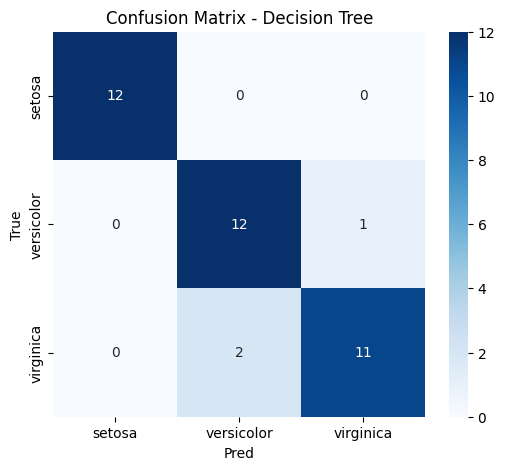

In [20]:
# Ajustar modelo final con mejores parámetros (ya lo hace GridSearchCV con refit=True)
best_dt_pipeline = grid_dt.best_estimator_

# Evaluación en conjunto de prueba
y_pred_dt = best_dt_pipeline.predict(X_test)
print('\n--- Evaluación Decision Tree en test set ---')
print('Accuracy:', accuracy_score(y_test, y_pred_dt))
print('\nClassification Report:\n', classification_report(y_test, y_pred_dt, target_names=CLASS_NAMES))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.ylabel('True')
plt.xlabel('Pred')
plt.title('Confusion Matrix - Decision Tree')
plt.show()

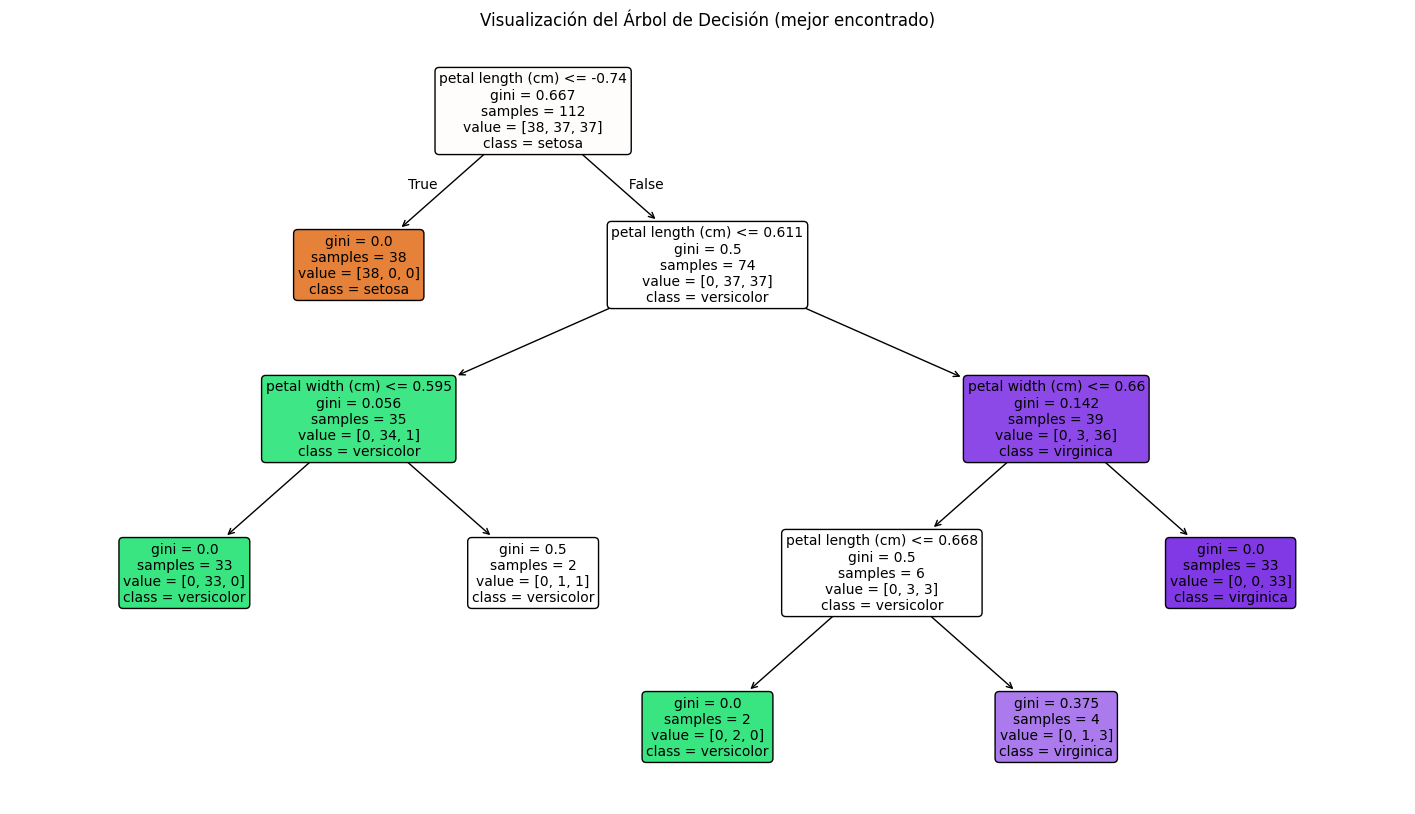

In [21]:
# Visualizar el árbol (limitado a profundidad para ser legible)
clf_dt = best_dt_pipeline.named_steps['clf']
plt.figure(figsize=(18, 10))
plot_tree(clf_dt, feature_names=X.columns, class_names=CLASS_NAMES, filled=True, rounded=True, fontsize=10)
plt.title('Visualización del Árbol de Decisión (mejor encontrado)')
plt.show()

In [22]:
# GridSearchCV para Random Forest
param_grid_rf = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [None, 5, 10, 20],
    'clf__max_features': ['sqrt', 'log2'],
    'clf__min_samples_leaf': [1, 2, 4]
}

# Empezar búsqueda
print('\nIniciando GridSearchCV para Random Forest...')
start = time.time()
grid_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid_rf,
    cv=CV_FOLDS,
    scoring=SCORING,
    n_jobs=-1,
    verbose=1
)
grid_rf.fit(X_train, y_train)
end = time.time()
print(f"GridSearch completo en {end-start:.1f} s")
print('Mejores parámetros (Random Forest):', grid_rf.best_params_)
print('Mejor score CV (Random Forest):', grid_rf.best_score_)


Iniciando GridSearchCV para Random Forest...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
GridSearch completo en 79.7 s
Mejores parámetros (Random Forest): {'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__n_estimators': 50}
Mejor score CV (Random Forest): 0.9549407114624506



--- Evaluación Random Forest en test set ---
Accuracy: 0.9210526315789473

Classification Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.86      0.92      0.89        13
   virginica       0.92      0.85      0.88        13

    accuracy                           0.92        38
   macro avg       0.92      0.92      0.92        38
weighted avg       0.92      0.92      0.92        38



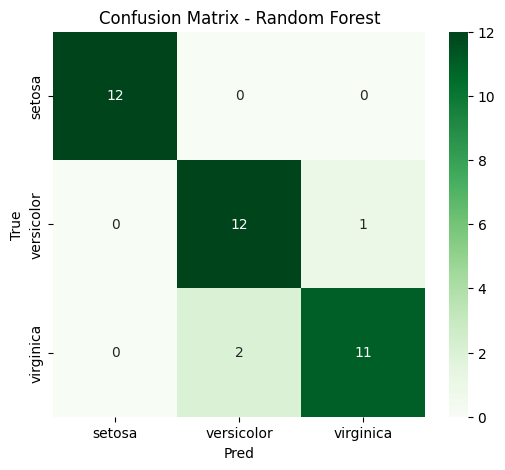

In [23]:
# Evaluación del mejor Random Forest
best_rf_pipeline = grid_rf.best_estimator_
rf_clf = best_rf_pipeline.named_steps['clf']

# Si quieres acceder al OOB score, habría que crear un RandomForestClassifier con oob_score=True
# y re-entrenarlo. GridSearch con Pipeline no lo activó necesariamente. Aquí mostramos importancia de características.

y_pred_rf = best_rf_pipeline.predict(X_test)
print('\n--- Evaluación Random Forest en test set ---')
print('Accuracy:', accuracy_score(y_test, y_pred_rf))
print('\nClassification Report:\n', classification_report(y_test, y_pred_rf, target_names=CLASS_NAMES))

cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.ylabel('True')
plt.xlabel('Pred')
plt.title('Confusion Matrix - Random Forest')
plt.show()

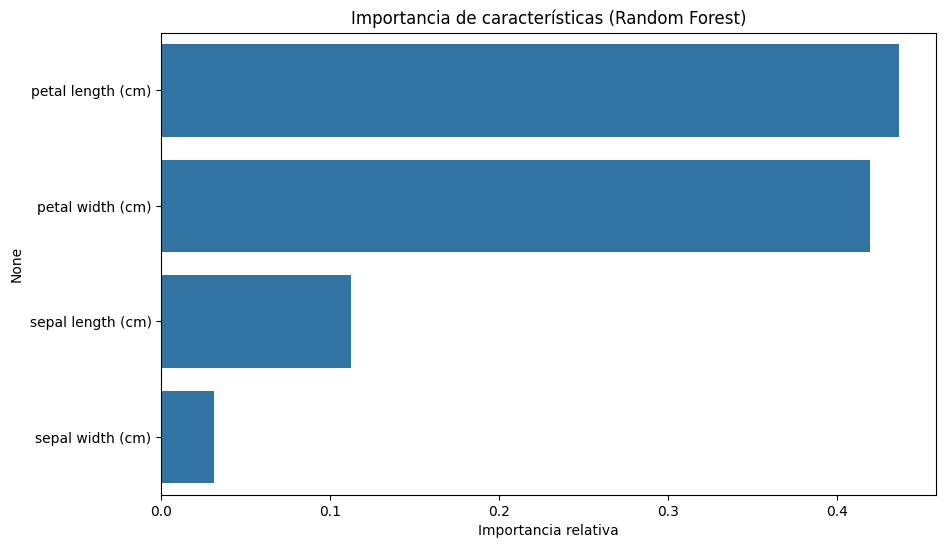

In [24]:
# Importancias de características (Random Forest)
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title('Importancia de características (Random Forest)')
sns.barplot(x=importances[indices], y=X.columns[indices])
plt.xlabel('Importancia relativa')
plt.show()

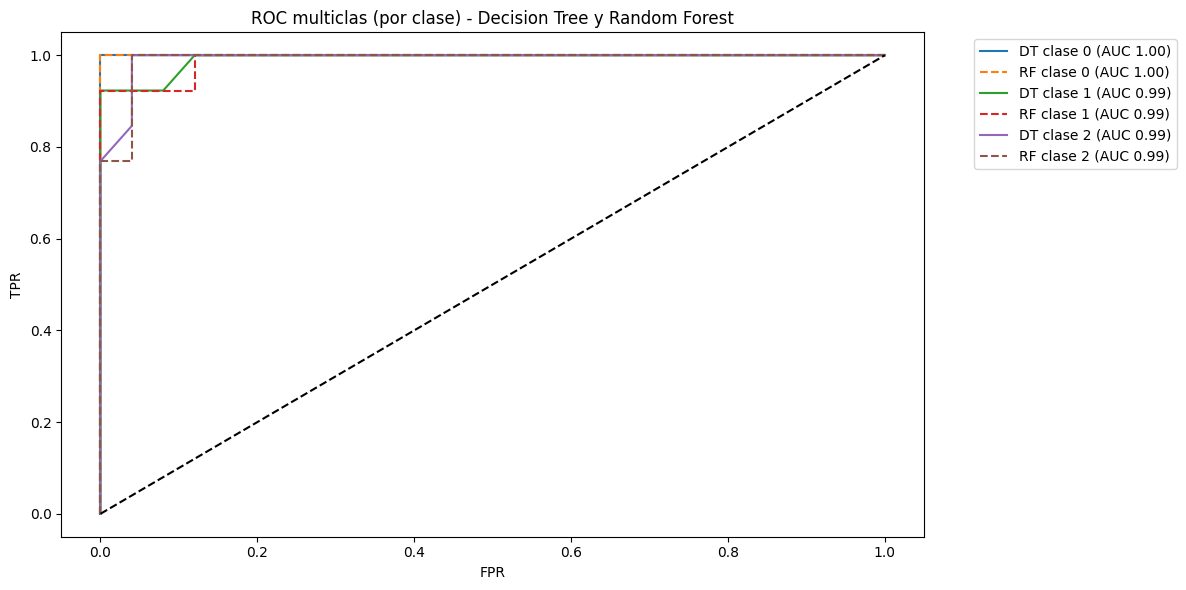

AUC por clase (Decision Tree): [1.    0.992 0.992]
AUC por clase (Random Forest): [1.    0.991 0.991]
AUC macro (Decision Tree): 0.9948717948717949
AUC macro (Random Forest): 0.9938461538461537


In [25]:
# ROC curves (multiclase) - convertimos a binarizado
# Algunas métricas requieren probabilidades; nos aseguramos de que los estimadores soporten predict_proba
from sklearn.preprocessing import LabelBinarizer

n_classes = len(CLASS_NAMES)

if n_classes == 2:
    # binario
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test)).ravel()
    # Decision Tree
    y_score_dt = best_dt_pipeline.predict_proba(X_test)[:, 1]
    fpr_dt, tpr_dt, _ = roc_curve(y_test_bin, y_score_dt)
    auc_dt = auc(fpr_dt, tpr_dt)
    # RF
    y_score_rf = best_rf_pipeline.predict_proba(X_test)[:, 1]
    fpr_rf, tpr_rf, _ = roc_curve(y_test_bin, y_score_rf)
    auc_rf = auc(fpr_rf, tpr_rf)
    plt.figure(figsize=(8,6))
    plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.3f})')
    plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC (binario)')
    plt.legend()
    plt.show()
else:
    # Multiclase: One-vs-Rest AUC por clase
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    # Decision Tree
    if hasattr(best_dt_pipeline, 'predict_proba') or hasattr(best_dt_pipeline.named_steps['clf'], 'predict_proba'):
        y_score_dt = best_dt_pipeline.predict_proba(X_test)
    else:
        # usar decision_function o fallback
        y_score_dt = best_dt_pipeline.decision_function(X_test)
    # Random Forest
    if hasattr(best_rf_pipeline, 'predict_proba') or hasattr(best_rf_pipeline.named_steps['clf'], 'predict_proba'):
        y_score_rf = best_rf_pipeline.predict_proba(X_test)
    else:
        y_score_rf = best_rf_pipeline.decision_function(X_test)

    # Calcular AUC por clase y macro
    aucs_dt = []
    aucs_rf = []
    plt.figure(figsize=(12, 6))
    for i in range(n_classes):
        fpr_dt, tpr_dt, _ = roc_curve(y_test_bin[:, i], y_score_dt[:, i])
        fpr_rf, tpr_rf, _ = roc_curve(y_test_bin[:, i], y_score_rf[:, i])
        auc_dt_i = auc(fpr_dt, tpr_dt)
        auc_rf_i = auc(fpr_rf, tpr_rf)
        aucs_dt.append(auc_dt_i)
        aucs_rf.append(auc_rf_i)
        plt.plot(fpr_dt, tpr_dt, label=f'DT clase {i} (AUC {auc_dt_i:.2f})')
        plt.plot(fpr_rf, tpr_rf, '--', label=f'RF clase {i} (AUC {auc_rf_i:.2f})')

    plt.plot([0,1],[0,1],'k--')
    plt.title('ROC multiclas (por clase) - Decision Tree y Random Forest')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    print('AUC por clase (Decision Tree):', np.round(aucs_dt, 3))
    print('AUC por clase (Random Forest):', np.round(aucs_rf, 3))
    print('AUC macro (Decision Tree):', np.mean(aucs_dt))
    print('AUC macro (Random Forest):', np.mean(aucs_rf))

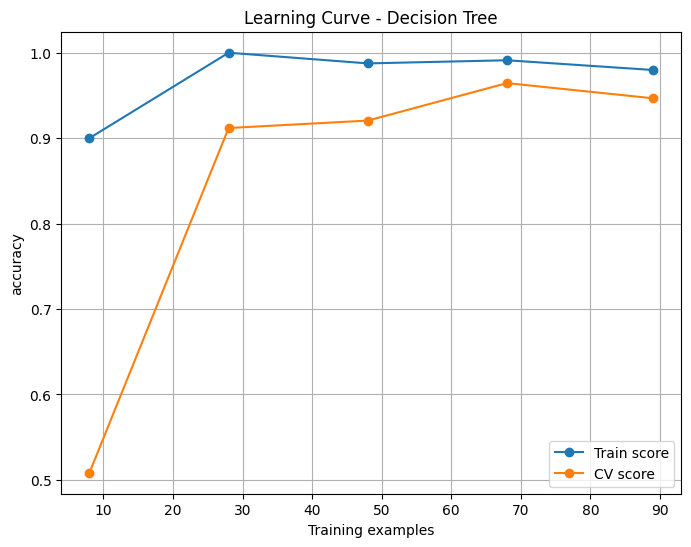

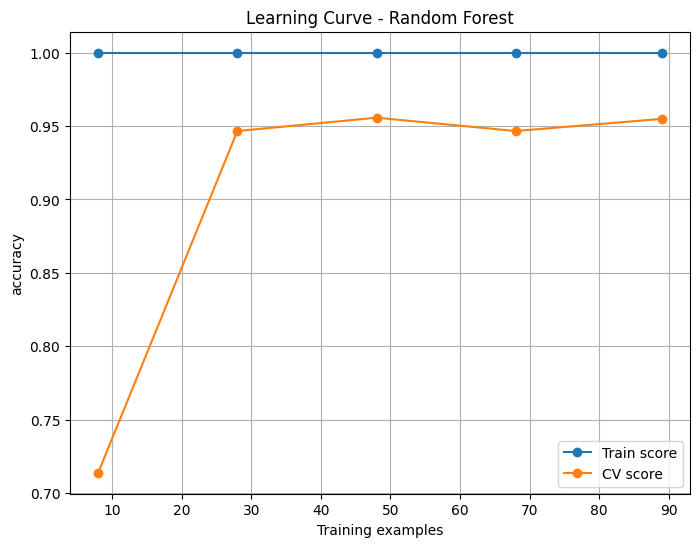

In [26]:

# Curvas de aprendizaje para ambos modelos (miden generalización vs tamaño de entrenamiento)
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, cv=5, scoring='accuracy'):
    plt.figure(figsize=(8,6))
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5), random_state=RANDOM_STATE
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.plot(train_sizes, train_scores_mean, 'o-', label='Train score')
    plt.plot(train_sizes, test_scores_mean, 'o-', label='CV score')
    plt.xlabel('Training examples')
    plt.ylabel(scoring)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Para ahorrar tiempo, usamos los mejores estimadores ya ajustados (pero learning_curve recalcula internamente)
plot_learning_curve(best_dt_pipeline, 'Learning Curve - Decision Tree', X_train, y_train, cv=CV_FOLDS, scoring=SCORING)
plot_learning_curve(best_rf_pipeline, 'Learning Curve - Random Forest', X_train, y_train, cv=CV_FOLDS, scoring=SCORING)


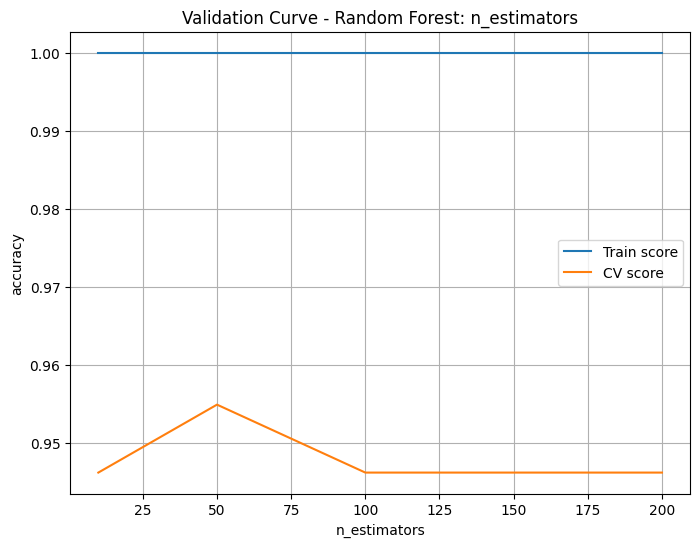

In [27]:

# Curva de validación (ejemplo: n_estimators en Random Forest)
param = 'clf__n_estimators'
param_range = [10, 50, 100, 200]
train_scores, test_scores = validation_curve(
    best_rf_pipeline, X_train, y_train, param_name=param, param_range=param_range,
    cv=CV_FOLDS, scoring=SCORING, n_jobs=-1
)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(param_range, train_mean, label='Train score')
plt.plot(param_range, test_mean, label='CV score')
plt.xlabel('n_estimators')
plt.ylabel(SCORING)
plt.title('Validation Curve - Random Forest: n_estimators')
plt.legend()
plt.grid(True)
plt.show()

In [28]:

# Guardar modelos con joblib para uso posterior
joblib.dump(best_dt_pipeline, 'best_decision_tree_pipeline.joblib')
joblib.dump(best_rf_pipeline, 'best_random_forest_pipeline.joblib')
print('Modelos guardados: best_decision_tree_pipeline.joblib, best_random_forest_pipeline.joblib')

# %%
# Resumen rápido
print('\n--- Resumen rápido ---')
print('Decision Tree CV score (mejor):', grid_dt.best_score_)
print('Decision Tree test accuracy: ', accuracy_score(y_test, y_pred_dt))
print('\nRandom Forest CV score (mejor):', grid_rf.best_score_)
print('Random Forest test accuracy: ', accuracy_score(y_test, y_pred_rf))

print('\nFin del notebook. Puedes modificar parámetros, explorar más métricas o probar otros datasets.')

Modelos guardados: best_decision_tree_pipeline.joblib, best_random_forest_pipeline.joblib

--- Resumen rápido ---
Decision Tree CV score (mejor): 0.9375494071146244
Decision Tree test accuracy:  0.9210526315789473

Random Forest CV score (mejor): 0.9549407114624506
Random Forest test accuracy:  0.9210526315789473

Fin del notebook. 


In [29]:
###

In [30]:
# En pocas palabras: el análisis nos sirve para entender qué tan bien los modelos pueden clasificar, qué variables son más importantes, y cuál modelo es más confiable para tomar decisiones con nuevos datos.